<a href="https://colab.research.google.com/github/BelalMJ/BelalMJ_64061/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset Download and Extraction, and Understanding the Time-Series Forecasting Problem

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import zipfile
import matplotlib.pyplot as plt

# Download and extract dataset with error handling
try:
    zip_path = keras.utils.get_file(
        origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
        fname="jena_climate_2009_2016.csv.zip",
        extract=False
    )
    extract_dir = os.path.join(os.path.expanduser('~'), '.keras', 'datasets')
    os.makedirs(extract_dir, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Dataset downloaded and extracted successfully")
except Exception as e:
    print(f"Error occurred: {e}")
    raise

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dataset downloaded and extracted successfully


# Loading and Inspection the data

In [ ]:
# Load dataset with validation
csv_path = os.path.join(extract_dir, 'jena_climate_2009_2016.csv')
try:
    df = pd.read_csv(csv_path)
    print(f"Dataset loaded successfully with {len(df)} rows")
    print(df.head())
except Exception as e:
    print(f"Error loading CSV: {e}")
    raise

Dataset loaded successfully with 420551 rows
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s) 

# Data Preperation (Normalization)

In [ ]:
# Normalize data with validation
try:
    float_data = df.iloc[:, 1:].values
    mean = float_data[:200000].mean(axis=0)
    float_data -= mean
    std = float_data[:200000].std(axis=0)
    float_data /= std
    print("Data normalized successfully")
except Exception as e:
    print(f"Error normalizing data: {e}")
    raise

Data normalized successfully


# Data Generator Function

In [ ]:
# Optimized generator function
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback

    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]  # Temperature

        yield samples, targets

#  Parameter Configuration

In [ ]:
# Parameters with explanations
lookback = 1440    # 10 days in minutes (10 * 144)
step = 6           # Sample every hour (60 min / 10)
delay = 144        # Predict 24 hours ahead (144 / 6 = 24)
batch_size = 128   # Reasonable batch size
epochs = 40        # Maximum epochs (early stopping will likely stop earlier)

print(f"Parameters set: lookback={lookback}, step={step}, delay={delay}, batch_size={batch_size}, epochs={epochs}")

Parameters set: lookback=1440, step=6, delay=144, batch_size=128, epochs=40


# Data Generators Setup

In [ ]:
# Prepare generators with validation
try:
    train_gen = generator(float_data, lookback, delay, 0, 200000, True, batch_size, step)
    val_gen = generator(float_data, lookback, delay, 200001, 300000, False, batch_size, step)
    test_gen = generator(float_data, lookback, delay, 300001, None, False, batch_size, step)

    val_steps = (300000 - 200001 - lookback) // batch_size
    test_steps = (len(float_data) - 300001 - lookback) // batch_size

    print(f"Generators created: val_steps={val_steps}, test_steps={test_steps}")
except Exception as e:
    print(f"Error creating generators: {e}")
    raise

Generators created: val_steps=769, test_steps=930


# Callbacks Configuration

In [ ]:
# callbacks with learning rate tracking
class LRLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = float(keras.backend.get_value(self.model.optimizer.learning_rate))
        return logs

lr_logger = LRLogger()

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Callbacks configured: LearningRateScheduler, EarlyStopping, and LRLogger")

Callbacks configured: LearningRateScheduler, EarlyStopping, and LRLogger


# Model Architectures

In [ ]:
# Model building with summaries
models = {}
input_shape = (None, float_data.shape[-1])

# Basic GRU Model
models['GRU'] = keras.Sequential([
    layers.GRU(32, input_shape=input_shape),
    layers.Dense(1)
], name="Basic_GRU")

# Stacked GRU with More Units
models['Stacked_GRU'] = keras.Sequential([
    layers.GRU(64, return_sequences=True, input_shape=input_shape),
    layers.GRU(64),
    layers.Dense(1)
], name="Stacked_GRU")

# Using LSTM Instead of GRU
models['LSTM'] = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=input_shape),
    layers.LSTM(64),
    layers.Dense(1)
], name="Stacked_LSTM")

# CNN-RNN Hybrid, 1D ConvNet + RNN
models['CNN_RNN'] = keras.Sequential([
    layers.Conv1D(64, 5, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(3),
    layers.Conv1D(64, 5, activation='relu'),
    layers.GRU(64, return_sequences=True),
    layers.GRU(64),
    layers.Dense(1)
], name="CNN_RNN_Hybrid")

# GRU with Dropout. Adding Dropout and Recurrent Dropout
models['GRU_Dropout'] = keras.Sequential([
    layers.GRU(64, dropout=0.2, recurrent_dropout=0.2,
              return_sequences=True, input_shape=input_shape),
    layers.GRU(64, dropout=0.2, recurrent_dropout=0.2),
    layers.Dense(1)
], name="GRU_with_Dropout")

# Bidirectional GRU
models['Bi_GRU'] = keras.Sequential([
    layers.Bidirectional(layers.GRU(32), input_shape=input_shape),
    layers.Dense(1)
], name="Bidirectional_GRU")

# Print summaries
for name, model in models.items():
    print(f"\n{name} Architecture:")
    model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



GRU Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Basic_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 32)                  │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)


Stacked_GRU Architecture:


Model: "Stacked_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, None, 64)            │          15,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,385 (157.75 KB)

 Trainable params: 40,385 (157.75 KB)

 Non-trainable params: 0 (0.00 B)


LSTM Architecture:


Model: "Stacked_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 64)            │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)


CNN_RNN Architecture:


Model: "CNN_RNN_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, None, 64)            │           4,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, None, 64)            │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, None, 64)            │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,073 (293.25 KB)

 Trainable params: 75,073 (293.25 KB)

 Non-trainable params: 0 (0.00 B)


GRU_Dropout Architecture:


Model: "GRU_with_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                          │ (None, None, 64)            │          15,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,385 (157.75 KB)

 Trainable params: 40,385 (157.75 KB)

 Non-trainable params: 0 (0.00 B)


Bi_GRU Architecture:


Model: "Bidirectional_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 64)                  │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,281 (36.25 KB)

 Trainable params: 9,281 (36.25 KB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [ ]:
# Training with results printing
history_dict = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")

    # Initialize optimizer with explicit learning rate
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mae')

    history = model.fit(
        train_gen,
        steps_per_epoch=100,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=val_steps,
        callbacks=[lr_scheduler, early_stopping, lr_logger],
        verbose=1
    )
    history_dict[name] = history

    # Print training results summary
    best_epoch = np.argmin(history.history['val_loss'])
    print(f"\nTraining completed for {name}:")
    print(f"- Best validation MAE: {history.history['val_loss'][best_epoch]:.4f} (epoch {best_epoch + 1})")
    print(f"- Final validation MAE: {history.history['val_loss'][-1]:.4f}")
    print(f"- Training epochs: {len(history.history['loss'])}")
    if 'lr' in history.history:
        print(f"- Final learning rate: {history.history['lr'][-1]:.2e}")
    print(f"{'='*50}")


Training GRU...
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 587ms/step - loss: 0.4937 - val_loss: 0.2857 - learning_rate: 0.0010 - lr: 0.0010
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 814ms/step - loss: 0.3044 - val_loss: 0.2808 - learning_rate: 0.0010 - lr: 0.0010
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 546ms/step - loss: 0.2982 - val_loss: 0.2788 - learning_rate: 0.0010 - lr: 0.0010
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 538ms/step - loss: 0.2967 - val_loss: 0.2756 - learning_rate: 0.0010 - lr: 0.0010
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 536ms/step - loss: 0.2909 - val_loss: 0.2722 - learning_rate: 0.0010 - lr: 0.0010
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 533ms/step - loss: 0.2878 - val_loss: 0.2720 - learning_rate: 0.0010 - lr: 0.0010
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 535ms/step - loss: 0.2889 - val_loss: 0.2761 - learning_rate: 0.0010 - lr: 0.0010
Epoch 8/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 817ms/step - loss: 0.2787 - val_loss: 0.2722 - learning_r

#  Model Evaluation

In [ ]:
# Comprehensive evaluation for all models
test_mae_results = {}

print("\nModel Evaluation Results:")
for name, model in models.items():
    test_mae = model.evaluate(test_gen, steps=test_steps, verbose=0)
    test_mae_results[name] = test_mae
    print(f"{name}: Test MAE = {test_mae:.4f}")


Model Evaluation Results:
GRU: Test MAE = 0.2775
Stacked_GRU: Test MAE = 0.2747
LSTM: Test MAE = 0.2842
CNN_RNN: Test MAE = 0.3066
GRU_Dropout: Test MAE = 0.2854
Bi_GRU: Test MAE = 0.2728


# Performance Visualization

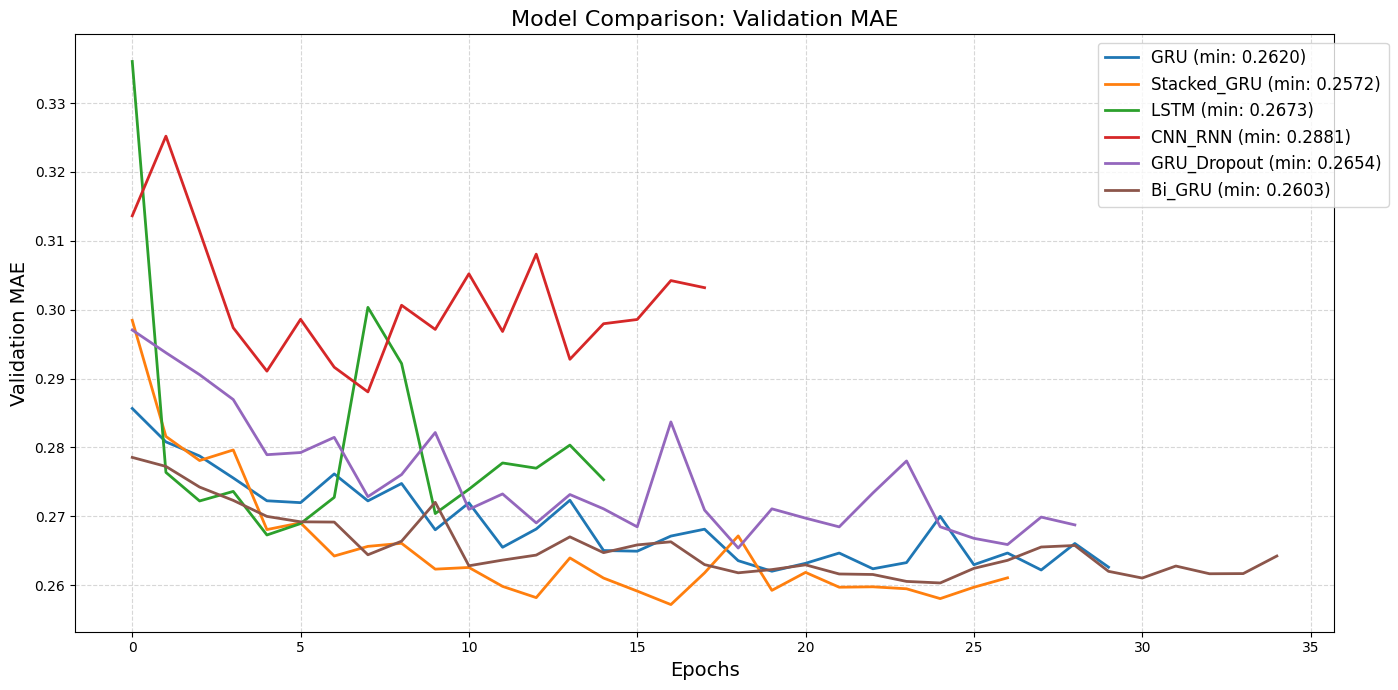

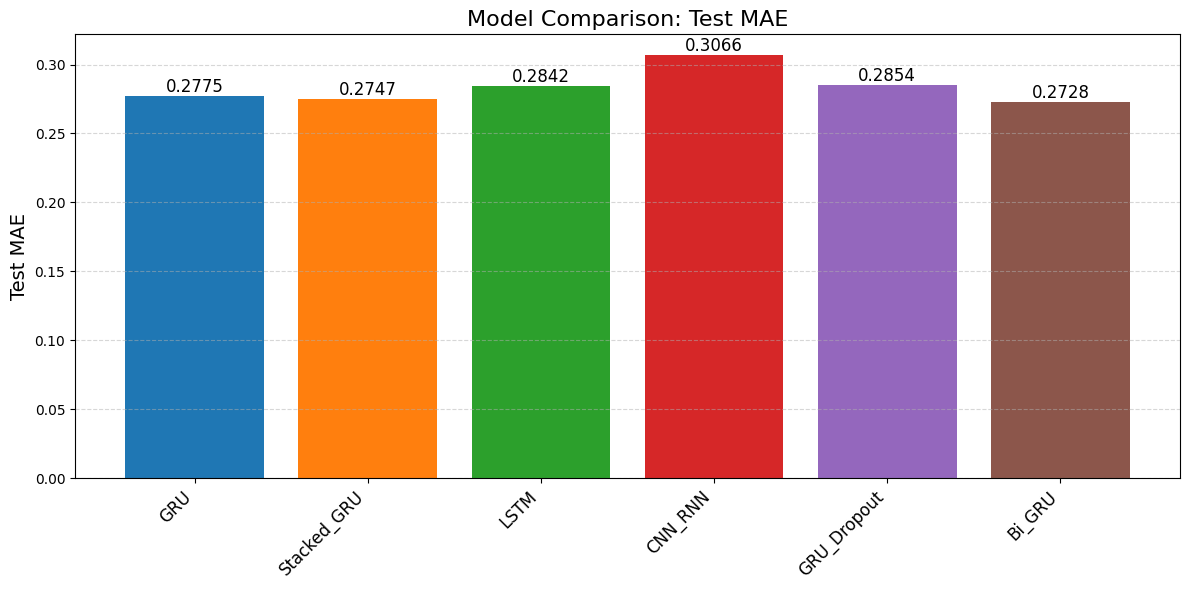

In [ ]:
# Visualize all models for validation and testing MAE results
plt.figure(figsize=(14, 7))
colors = plt.cm.tab10.colors

for i, (name, history) in enumerate(history_dict.items()):
    plt.plot(history.history['val_loss'],
             color=colors[i],
             linewidth=2,
             label=f'{name} (min: {min(history.history["val_loss"]):.4f})')

plt.title('Model Comparison: Validation MAE', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation MAE', fontsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Test MAE comparison
plt.figure(figsize=(12, 6))
bars = plt.bar(test_mae_results.keys(), test_mae_results.values(),
               color=colors[:len(test_mae_results)])

plt.title('Model Comparison: Test MAE', fontsize=16)
plt.ylabel('Test MAE', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Results Comparison Table

In [ ]:
# Detailed comparison table with safe LR access
comparison_data = []
for name, history in history_dict.items():
    row = {
        'Model': name,
        'Best Val MAE': min(history.history['val_loss']),
        'Final Val MAE': history.history['val_loss'][-1],
        'Test MAE': test_mae_results[name],
        'Parameters': f"{models[name].count_params():,}",
        'Training Epochs': len(history.history['loss'])
    }

    # Safely get final learning rate
    try:
        row['Final LR'] = float(history.history['lr'][-1])
    except KeyError:
        row['Final LR'] = 'N/A'

    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
display(comparison_df.style
       .background_gradient(subset=['Best Val MAE', 'Test MAE'], cmap='RdYlGn_r')
       .format({'Best Val MAE': '{:.4f}',
                'Final Val MAE': '{:.4f}',
                'Test MAE': '{:.4f}'}))


Model Performance Comparison:


,Model,Best Val MAE,Final Val MAE,Test MAE,Parameters,Training Epochs,Final LR
0,GRU,0.2620,0.2626,0.2775,"4,641",30,0.000250
1,Stacked_GRU,0.2572,0.2611,0.2747,"40,385",27,0.000250
2,LSTM,0.2673,0.2753,0.2842,"53,313",15,0.000250
3,CNN_RNN,0.2881,0.3032,0.3066,"75,073",18,0.000250
4,GRU_Dropout,0.2654,0.2687,0.2854,"40,385",29,0.000250
5,Bi_GRU,0.2603,0.2642,0.2728,"9,281",35,0.000125
